In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import json
import cv2

# 모델 및 데이터셋 클래스 임포트
from models import Net
from custom_transforms import Rescale, Normalize, ToTensor, RandomCrop, RandomHorizontalFlip
from facial_keypoints_dataset import CatKeypointsDataset

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import torch

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("Using device:", device)


In [17]:
import cv2
import numpy as np
import os
import json
from torch.utils.data import Dataset

class CatKeypointsDataset(Dataset):
    def __init__(self, labels_dir, images_dir, transform=None):
        self.labels_dir = labels_dir
        self.images_dir = images_dir
        self.data = self._load_data()
        self.transform = transform

    def _load_data(self):
        data = []
        for label_file in os.listdir(self.labels_dir):
            if label_file.endswith('.json'):
                with open(os.path.join(self.labels_dir, label_file), 'r') as file:
                    labels = json.load(file)
                    img_file = label_file.replace('.json', '.png')
                    data.append({'image': img_file, 'labels': labels['labels'], 'bounding_box': labels['bounding_boxes']})
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.data[idx]['image'])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        keypoints = np.array(self.data[idx]['labels']).astype('float32').reshape(-1, 2)
        bounding_box = np.array(self.data[idx]['bounding_box'])

        # 원본 이미지 크기
        original_height, original_width = image.shape[:2]

        # 이미지 크기가 224보다 작은 경우, 비율을 유지하며 224x224로 확대
        if original_width < 224 or original_height < 224:
            scale = max(224 / original_width, 224 / original_height)
            new_width = int(original_width * scale)
            new_height = int(original_height * scale)
            image = cv2.resize(image, (new_width, new_height))
            
            # 키포인트도 같은 비율로 확대
            keypoints[:, 0] *= scale
            keypoints[:, 1] *= scale
            
            # 224x224로 중앙 자르기 (crop)
            start_x = (new_width - 224) // 2
            start_y = (new_height - 224) // 2
            image = image[start_y:start_y + 224, start_x:start_x + 224]
            
            # 키포인트도 crop에 맞게 이동
            keypoints[:, 0] -= start_x
            keypoints[:, 1] -= start_y
        else:
            # 이미지 크기를 224x224로 조정
            image = cv2.resize(image, (224, 224))
            
            # 키포인트도 224x224 크기에 맞게 조정
            keypoints[:, 0] *= (224.0 / original_width)
            keypoints[:, 1] *= (224.0 / original_height)
        
        sample = {'image': image, 'keypoints': keypoints, 'bounding_box': bounding_box}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [18]:
device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [19]:
# 데이터 경로 설정
labels_dir = '/home/work/XAI/BITAmin/CatFLW/labels'
images_dir = '/home/work/XAI/BITAmin/CatFLW/images'

data_transform = transforms.Compose([
    Rescale((250)),  # 크기를 224x224로 조정
    RandomCrop(224),
    RandomHorizontalFlip(),
    Normalize(color=True),  # RGB로 유지
    ToTensor()
])


In [20]:
train_dataset = CatKeypointsDataset(labels_dir=labels_dir, images_dir=images_dir, transform=data_transform)
test_dataset = CatKeypointsDataset(labels_dir=labels_dir, images_dir=images_dir, transform=data_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [21]:
# 모델 인스턴스화 및 출력
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [22]:
# 네트워크 샘플 출력 함수
def net_sample_output(model, test_loader):
    for i, sample in enumerate(test_loader):
        images = sample["image"].to(device)
        key_pts = sample["keypoints"].to(device)

        images = images.type(torch.FloatTensor).to(device)
        output_pts = model(images)
        output_pts = output_pts.view(output_pts.size()[0], 48, 2)  # [batch_size, 48, 2]

        if i == 0:
            return images, output_pts, key_pts

# 함수 호출 및 출력 크기 확인
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)
print(test_images.size())  # Should be [batch_size, 3, 224, 224]
print(test_outputs.size())  # Should be [batch_size, 48, 2]
print(gt_pts.size())  # Should be [batch_size, 48, 2]

torch.Size([64, 3, 224, 224])
torch.Size([64, 48, 2])
torch.Size([64, 48, 2])


In [23]:
# 키포인트 시각화 함수
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    plt.imshow(image, cmap="gray")
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker=".", c="m")
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker=".", c="g")

In [24]:
# 시각화 함수
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)
        image = test_images[i].cpu().data.numpy()
        image = np.transpose(image, (1, 2, 0))
        predicted_key_pts = test_outputs[i].cpu().data.numpy()
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i].cpu().data.numpy()
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        plt.axis("off")
    plt.show()


In [25]:
criterion = nn.SmoothL1Loss()


In [26]:
# 손실 함수 및 옵티마이저 설정
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # 매 7 epoch마다 학습률을 10% 감소


In [27]:
# 네트워크 훈련 함수 정의
def train_net(n_epochs, patience=5):
    losses = []
    net.train()
    best_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(n_epochs):
        running_loss = 0.0
        for data in train_loader:
            images = data["image"].to(torch.device("cpu"))
            key_pts = data["keypoints"].to(torch.device("cpu"))
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor).to(torch.device("cpu"))
            images = images.type(torch.FloatTensor).to(torch.device("cpu"))
            
            optimizer.zero_grad()
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{n_epochs} loss: {epoch_loss}')

        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping!')
                break

        scheduler.step()  # 학습률 조정

    return losses

Epoch 1/17 loss: 0.7405601505077246
Epoch 2/17 loss: 0.4896986990263968
Epoch 3/17 loss: 0.41916379874402826
Epoch 4/17 loss: 0.39073409004644916
Epoch 5/17 loss: 0.35082232410257513
Epoch 6/17 loss: 0.3305804693337643
Epoch 7/17 loss: 0.30729928703019116
Epoch 8/17 loss: 0.27709042980815424
Epoch 9/17 loss: 0.27187415009195154
Epoch 10/17 loss: 0.27738406667203613
Epoch 11/17 loss: 0.26899369918938837
Epoch 12/17 loss: 0.2663698675054492
Epoch 13/17 loss: 0.2648440775546161
Epoch 14/17 loss: 0.2659445350820368
Epoch 15/17 loss: 0.26895684681155463
Epoch 16/17 loss: 0.25756909720825427
Epoch 17/17 loss: 0.25857669385996734


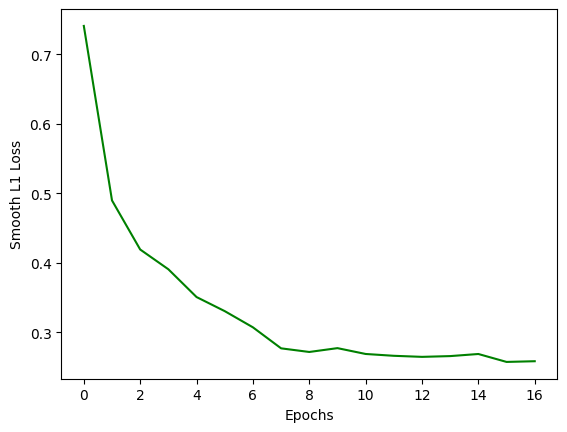

In [28]:
# 네트워크 훈련
n_epochs = 17
losses = train_net(n_epochs)
plt.xlabel("Epochs")
plt.ylabel("Smooth L1 Loss")
plt.plot(losses, "g-")

torch.Size([64, 3, 224, 224])
torch.Size([64, 48, 2])
torch.Size([64, 48, 2])


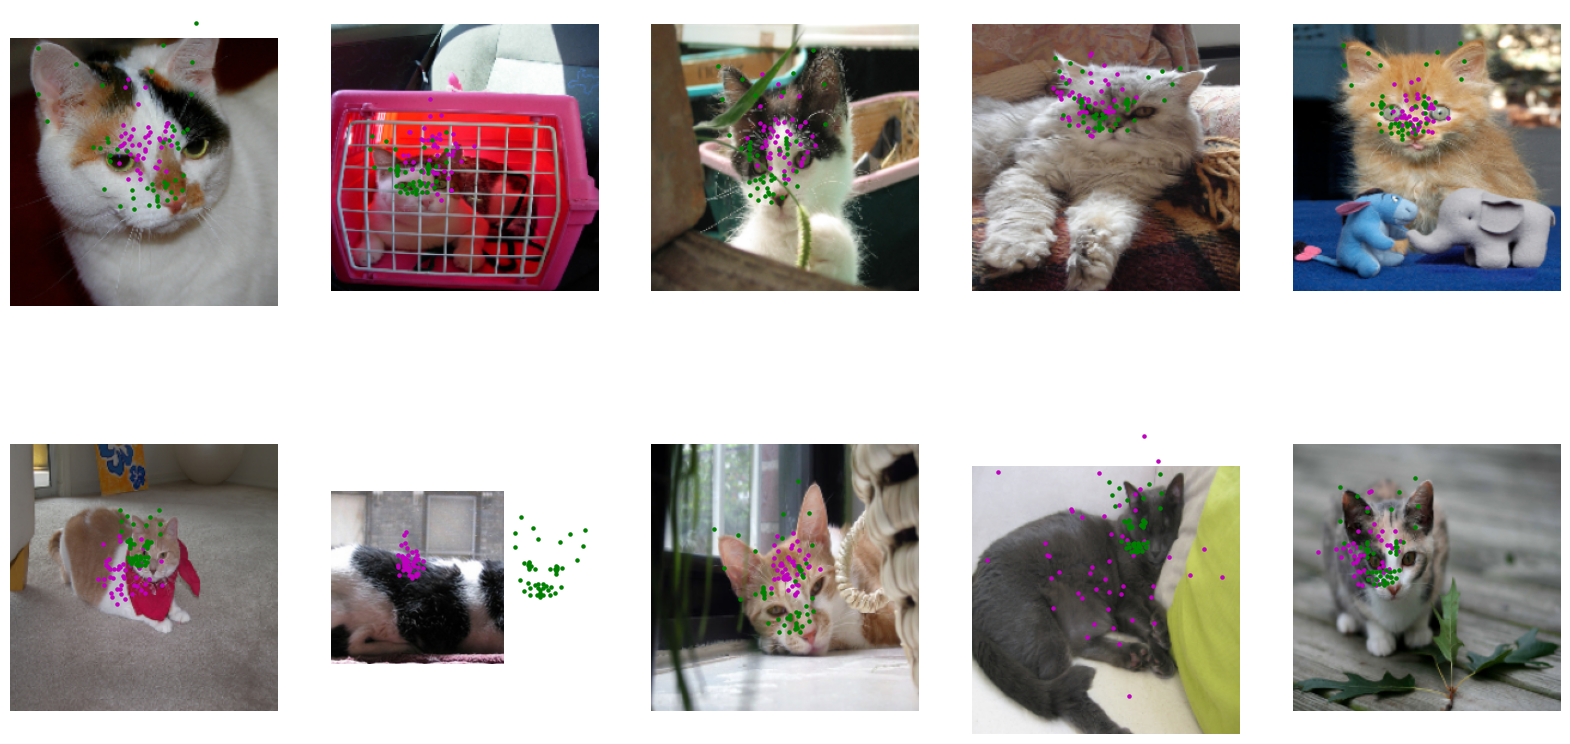

In [29]:
# 모델 저장
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_name = "cat_keypoints_model2.pt"
model_path = os.path.join(model_dir, model_name)
torch.save(net.state_dict(), model_path)

# 테스트 데이터 다시 가져오기
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)
print(test_images.size())
print(test_outputs.size())
print(gt_pts.size())

# 테스트 출력 시각화
visualize_output(test_images, test_outputs, gt_pts)

[[-0.08306832  0.03143829  0.09988927 -0.05823074]
 [ 0.00200425  0.07257646  0.04500727 -0.04883662]
 [-0.08726712  0.10850846 -0.11417092 -0.11572348]
 [ 0.08669375  0.05808315 -0.11478651 -0.14835703]]
(4, 4)


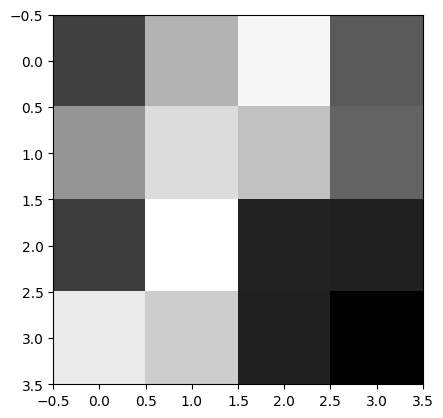

In [32]:
# 첫 번째 conv 레이어의 필터 가중치 시각화
weights1 = net.conv1.weight.data.cpu()
w = weights1.numpy()
filter_index = 0
print(w[filter_index][0])
print(w[filter_index][0].shape)
plt.imshow(w[filter_index][0], cmap="gray")

First convolutional layer


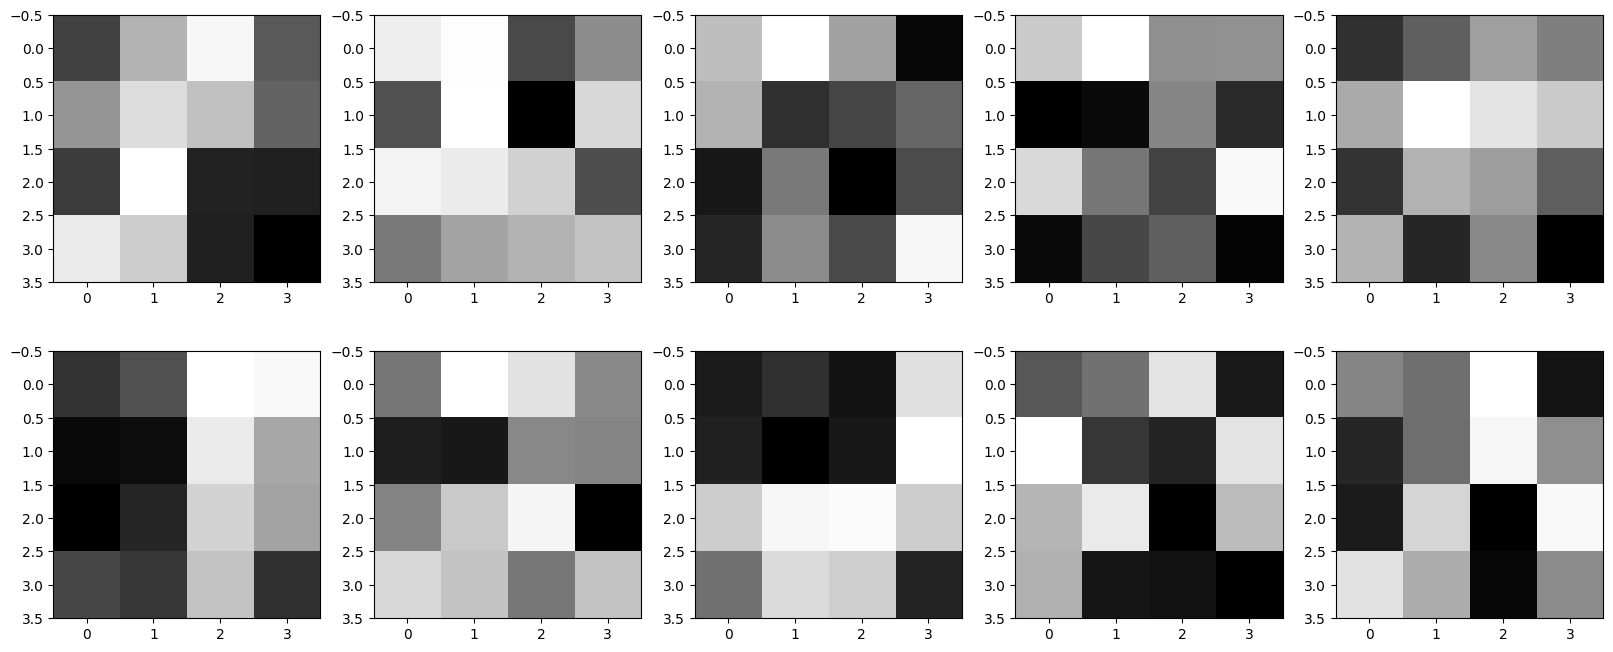

In [33]:
# 첫 번째 conv 레이어의 필터 시각화
weights = net.conv1.weight.data.cpu()
w = weights.numpy()
fig = plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(w[i][0], cmap="gray")
print("First convolutional layer")
plt.show()


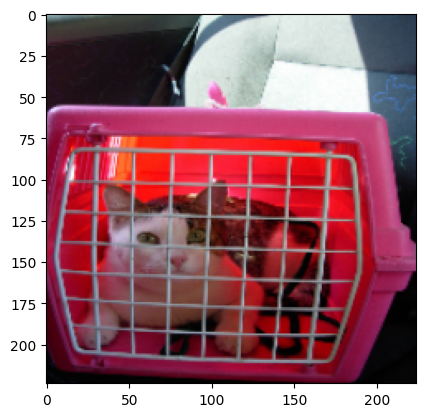

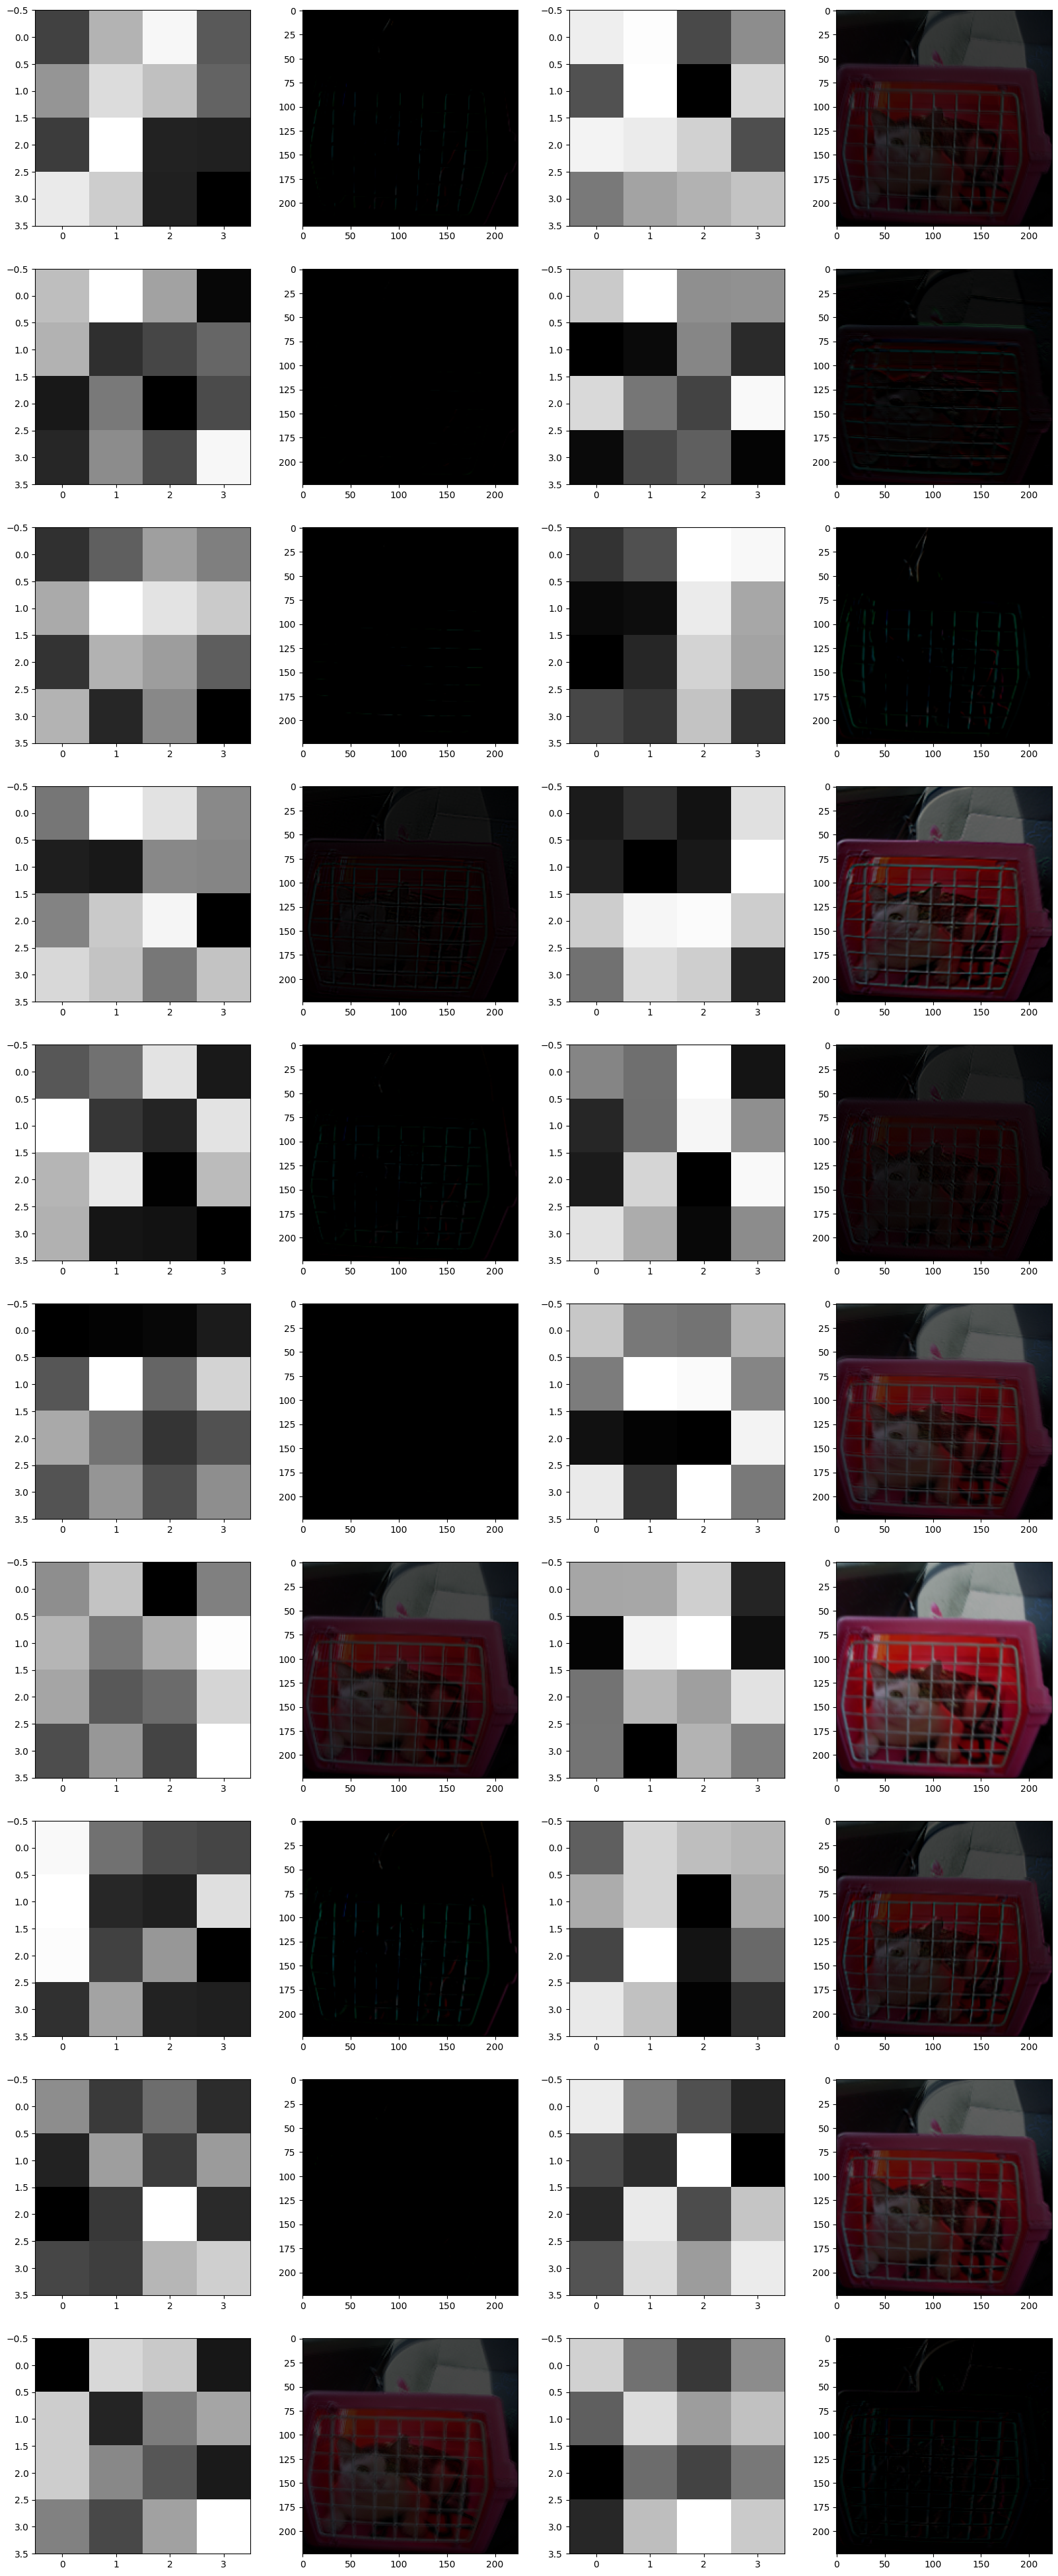

In [34]:
# 필터가 적용된 이미지 시각화
img = np.transpose(test_images[1].cpu().numpy(), (1, 2, 0))  # 형식을 (높이, 너비, 채널)로 변경
plt.imshow(img)
weights = net.conv1.weight.data.cpu()
w = weights.numpy()
fig = plt.figure(figsize=(20, 50))
columns = 4
rows = 10
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    if (i % 2) == 0:
        plt.imshow(w[int(i / 2)][0], cmap="gray")
    else:
        c = cv2.filter2D(img, -1, w[int((i - 1) / 2)][0])
        plt.imshow(c, cmap="gray")
plt.show()
